In [224]:
from random import random, randint
from colorama import Fore
from PIL import Image
import numpy as np
from time import sleep

class Maze:
  __maze = []
  __walls = []
  __breadcrumbs = []
  startpoint = []
  endpoint = []

  def __init__(self, height: int, width:int, startpoint=[], endpoint=[], breadcrumb=[[]]):
    
    self.__height = height
    self.__width = width

    if len(startpoint)==2:
      if (startpoint[0]!=1 and startpoint[0]!=height):
        raise ValueError(f"Start point [x,y] invalid, x must be eq. to 1 or {height}; provided: {startpoint[0]}")
      elif (startpoint[1]<1 | startpoint[1]>width):
        raise ValueError(f"Start point [x,y] invalid, y must be greater than 0 and less than {width+1}; provided: {startpoint[1]}")
      elif ((startpoint[0]==1 | startpoint[0]==height) and (startpoint[1]==width | startpoint[1]==1)):
        raise ValueError(f"Start point cant be in a edge; provided: {startpoint[0]}-{startpoint[1]}")
      else:
          self.startpoint = [None for i in range(2)]
          self.startpoint[0]=(startpoint[0]-1)
          self.startpoint[1]=(startpoint[1]-1)
    else:
      pass
    
    if len(endpoint)==2:
      if (endpoint[0]!=1 and endpoint[0]!=height):
        raise ValueError(f"End point [x,y] invalid, x must be eq. to 1 or {height}; provided: {endpoint[0]}")
      elif (endpoint[1]<1 | endpoint[1]>width):
        raise ValueError(f"End point [x,y] invalid, y must be greater than 0 and less than {width+1}; provided: {endpoint[1]}")
      elif ((endpoint[0]==1 | endpoint[0]==height) and (endpoint[1]==width | endpoint[1]==1)):
        raise ValueError(f"End point cant be in a edge; provided: {endpoint[0]}-{endpoint[1]}")
      else:
          self.endpoint = [None for i in range(2)]
          self.endpoint[0]=(endpoint[0]-1)
          self.endpoint[1]=(endpoint[1]-1)
    else:
      pass


  def getMaze(self) -> np.ndarray:
    return np.asarray(self.__maze)
  
  def printMaze(self):
    for i in range(0, self.__height):
      for j in range(0, self.__width):
        if (self.__maze[i][j] == 'u'):
          print(Fore.WHITE + str(self.__maze[i][j]), end=" ")
        elif (self.__maze[i][j] == 'c'):
          print(Fore.GREEN + str(self.__maze[i][j]), end=" ")
        elif (self.__maze[i][j] == 'bc'):
          print(Fore.YELLOW + str(self.__maze[i][j]), end=" ")
        else:
          print(Fore.RED + str(self.__maze[i][j]), end=" ")
        
      print('\n')
  
  def getMazeImage(self):

    a = np.zeros((self.__height,self.__width,3), dtype=np.int8)

    for i in range(0, self.__height):
      for j in range(0, self.__width):
        if (self.__maze[i][j] == 'c'):
          a[i,j]=[255,255,255]
        elif (self.__maze[i][j] == 'bc'):
          a[i,j]=[255,140,0]
        elif(self.__maze[i][j] == 'u'):
          a[i,j]=[124,252,0]
        else:
          a[i,j]=[0,0,0]
          
    im = Image.fromarray(a,mode="RGB")
    im.save("./maze.jpeg")

  def readMazeImage(self,path: str):
    
    im = Image.open(path)
    a = np.asarray(im)

    (height, width, rgb_dim) = a.shape

    self.__height = height
    self.__width = width
    self.__maze = [[None for j in range(width)] for i in range(height)]

    for i in range(0, self.__height):
      for j in range(0, self.__width):
        if (a[i,j]==[255,255,255]).all():
          self.__maze[i][j] = 'c'
        elif (a[i,j]==[0,0,0]).all():
          self.__maze[i][j] = 'w'
        else:
          self.__breadcrumbs.append([i,j])
          self.__maze[i][j] = 'bc'

    return self.getMaze()

  # Find number of surrounding cells
  def __surroundingCells(self, rand_wall):
    s_cells = 0
    if (self.__maze[rand_wall[0]-1][rand_wall[1]] == 'c'):
      s_cells += 1
    if (self.__maze[rand_wall[0]+1][rand_wall[1]] == 'c'):
      s_cells += 1
    if (self.__maze[rand_wall[0]][rand_wall[1]-1] == 'c'):
      s_cells +=1
    if (self.__maze[rand_wall[0]][rand_wall[1]+1] == 'c'):
      s_cells += 1
      
    return s_cells

  def __markUpperAsWall(self,rand_wall):
    if (rand_wall[0] != 0):
      if (self.__maze[rand_wall[0]-1][rand_wall[1]] != 'c'):
        self.__maze[rand_wall[0]-1][rand_wall[1]] = 'wb'
      if ([rand_wall[0]-1, rand_wall[1]] not in self.__walls):
        self.__walls.append([rand_wall[0]-1, rand_wall[1]])

  def __markLeftAsWall(self,rand_wall):
    if (rand_wall[1] != 0):
      if (self.__maze[rand_wall[0]][rand_wall[1]-1] != 'c'):
        self.__maze[rand_wall[0]][rand_wall[1]-1] = 'wb'
      if ([rand_wall[0], rand_wall[1]-1] not in self.__walls):
        self.__walls.append([rand_wall[0], rand_wall[1]-1])

  def __markRightAsWall(self,rand_wall):
    if (rand_wall[1] != self.__width-1):
      if (self.__maze[rand_wall[0]][rand_wall[1]+1] != 'c'):
        self.__maze[rand_wall[0]][rand_wall[1]+1] = 'wb'
      if ([rand_wall[0], rand_wall[1]+1] not in self.__walls):
        self.__walls.append([rand_wall[0], rand_wall[1]+1])

  def __markBottomAsWall(self,rand_wall):
    if (rand_wall[0] != self.__height-1):
      if (self.__maze[rand_wall[0]+1][rand_wall[1]] != 'c'):
        self.__maze[rand_wall[0]+1][rand_wall[1]] = 'wb'
      if ([rand_wall[0]+1, rand_wall[1]] not in self.__walls):
        self.__walls.append([rand_wall[0]+1, rand_wall[1]])
  
  def __deleteWall(self, rand_wall):
    for wall in self.__walls:
      if (wall[0] == rand_wall[0] and wall[1] == rand_wall[1]):
        self.__walls.remove(wall)

  def generate(self):
    # Denote all cells as unvisited
    # Create an empty list of list (matrix) with height x width dimension
    for i in range(0, self.__height):
      line = []
      for j in range(0, self.__width):
        line.append('u')
      self.__maze.append(line)

    # Randomize starting point and set it a cell
    # Generate a random point inside the list of list (matrix)
    # The starting point must not be in the corner of the matrix
    # so range over 1 to width-2 and 1 to height-2

    if len(self.startpoint)==2:

      if (self.startpoint[0]==0):
        starting_height=self.startpoint[0]+1
      elif self.startpoint[0]==(self.__height-1):
        starting_height=self.startpoint[0]-1
      else:       
        starting_height=self.startpoint[0]

      if (self.startpoint[1]==0):
        starting_width=self.startpoint[1]+1
      elif (self.startpoint[1]==self.__width-1):
        starting_width=self.startpoint[0]-1
      else:       
        starting_width=self.startpoint[1]

    else:
      starting_height = randint(1,(self.__height-2))
      starting_width = randint(1,(self.__width-2))

    # Mark it as cell and add surrounding walls to the list
    self.__maze[starting_height][starting_width] = 'c'
    self.__walls.append([starting_height - 1, starting_width])
    self.__walls.append([starting_height, starting_width - 1])
    self.__walls.append([starting_height, starting_width + 1])
    self.__walls.append([starting_height + 1, starting_width])

    # Denote walls in maze
    self.__maze[starting_height-1][starting_width] = 'w'
    self.__maze[starting_height][starting_width - 1] = 'w'
    self.__maze[starting_height][starting_width + 1] = 'w'
    self.__maze[starting_height + 1][starting_width] = 'w'

    while (self.__walls):
      # Pick a random wall
      rand_wall = self.__walls[int(random()*len(self.__walls))-1]

      # Check if it is a left wall
      if (rand_wall[1] != 0):
        # If on the left there is an Untrucked and on the right there is a Cell
        # U W C
        if (self.__maze[rand_wall[0]][rand_wall[1]-1] == 'u' and self.__maze[rand_wall[0]][rand_wall[1]+1] == 'c'):
          # Find the number of surrounding cells
          s_cells = self.__surroundingCells(rand_wall)

          if (s_cells < 2):
            # Denote the new path
            self.__maze[rand_wall[0]][rand_wall[1]] = 'c'

            # Mark the new walls
            self.__markUpperAsWall(rand_wall)
            self.__markBottomAsWall(rand_wall)
            self.__markLeftAsWall(rand_wall)
        
          # Delete wall
          self.__deleteWall(rand_wall)
          continue

      # Check if it is an upper wall
      if (rand_wall[0] != 0):
        # U
        # W
        # C
        if (self.__maze[rand_wall[0]-1][rand_wall[1]] == 'u' and self.__maze[rand_wall[0]+1][rand_wall[1]] == 'c'):

          s_cells = self.__surroundingCells(rand_wall)
          if (s_cells < 2):
            # Denote the new path
            self.__maze[rand_wall[0]][rand_wall[1]] = 'c'

            # Mark the new walls
            self.__markUpperAsWall(rand_wall)
            self.__markLeftAsWall(rand_wall)
            self.__markRightAsWall(rand_wall)

          # Delete wall
          self.__deleteWall(rand_wall)
          continue

      # Check the bottom wall
      if (rand_wall[0] != self.__height-1):
        # C
        # W
        # U
        if (self.__maze[rand_wall[0]+1][rand_wall[1]] == 'u' and self.__maze[rand_wall[0]-1][rand_wall[1]] == 'c'):

          s_cells = self.__surroundingCells(rand_wall)
          if (s_cells < 2):
            # Denote the new path
            self.__maze[rand_wall[0]][rand_wall[1]] = 'c'

            # Mark the new walls
            self.__markBottomAsWall(rand_wall)
            self.__markLeftAsWall(rand_wall)
            self.__markRightAsWall(rand_wall)

          # Delete wall
          self.__deleteWall(rand_wall)
          continue

      # Check the right wall
      if (rand_wall[1] != self.__width-1):
        # C W U
        if (self.__maze[rand_wall[0]][rand_wall[1]+1] == 'u' and self.__maze[rand_wall[0]][rand_wall[1]-1] == 'c'):

          s_cells = self.__surroundingCells(rand_wall)
          if (s_cells < 2):
            # Denote the new path
            self.__maze[rand_wall[0]][rand_wall[1]] = 'c'
            # Mark the new walls
            self.__markRightAsWall(rand_wall)
            self.__markBottomAsWall(rand_wall)
            self.__markUpperAsWall(rand_wall)

          # Delete wall
          self.__deleteWall(rand_wall)
          continue
      
      # if (self.__surroundingWalls(rand_wall)>3):
      #   self.__deleteWall(rand_wall)
      
      self.__deleteWall(rand_wall)
      
    # Mark the remaining unvisited cells as walls
    for i in range(0, self.__height):
      for j in range(0, self.__width):
        if (self.__maze[i][j] == 'u'):
          self.__maze[i][j] = 'w'

    # Set entrance
    if len(self.startpoint)==2:
      self.__maze[self.startpoint[0]][self.startpoint[1]] = 'c'
    else:
      for i in range(0, self.__width):
        if (self.__maze[1][i] == 'c'):
          self.__maze[0][i] = 'c'
          break

    # Set exit
    if len(self.endpoint)==2:
      self.__maze[self.endpoint[0]][self.endpoint[1]] = 'c'
    else:
      for i in range(self.__width-1, 0, -1):
        if (self.__maze[self.__height-2][i] == 'c'):
          self.__maze[self.__height-1][i] = 'c'
          break


In [225]:
#from utilities.maze import Maze
p = Maze(7,7)
p.generate()
p.getMazeImage()

In [240]:
from PIL import Image
im = Image.open('./provaImmagineDef.png')
im.save('./provaImmagineDef.jpeg')

OSError: cannot write mode RGBA as JPEG

In [18]:
#import aspose.words as aw
##prendiamo il file tiff generato dal json e lo mettiamo in formato jpeg
#doc = aw.Document()
#builder = aw.DocumentBuilder(doc)
#
#shape = builder.insert_image("./prova.tiff")
#shape.image_data.save("./prova.jpeg")



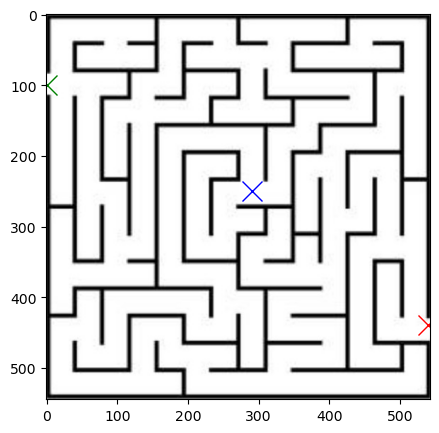

In [258]:
import numpy as np
import matplotlib.pylab as plt
from skimage.morphology import skeletonize
#leggo e ristampo l'immagine
img_name = './provaImmagineDef.jpeg'
rgb_img = plt.imread(img_name)

plt.figure(figsize=(5,5))
plt.imshow(rgb_img)

#segno con delle x il punto di partenza e di arrivo
x0,y0 = 0, 100
x1,y1 = 540, 440
x2,y2 = 290, 250

plt.plot(x0,y0, 'gx', markersize = 14)
plt.plot(x1,y1, 'rx', markersize = 14)
plt.plot(x2,y2, 'bx', markersize = 14)


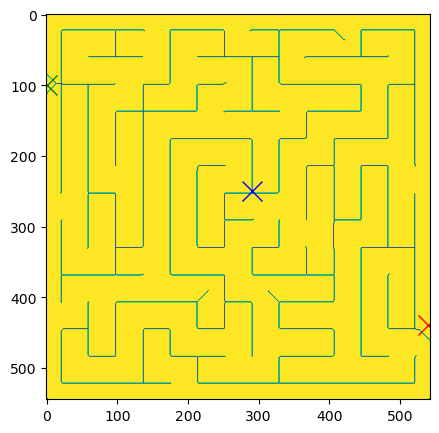

In [259]:
thr_img = rgb_img[:,:,0] > 128
skeleton = skeletonize(thr_img)
plt.figure(figsize=(5,5))
plt.imshow(skeleton)
#map of routes
mapT = ~skeleton
plt.imshow(mapT)
plt.plot(x0,y0, 'gx', markersize=14)
plt.plot(x1,y1, 'rx', markersize=14)
plt.plot(x2,y2, 'bx', markersize = 14)
#plt.plot(x,y, 'ro')

Optimum route found.
Optimum route found.


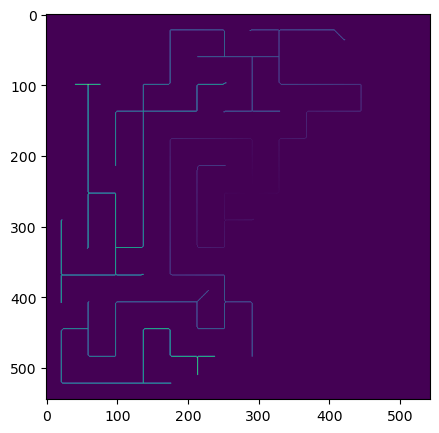

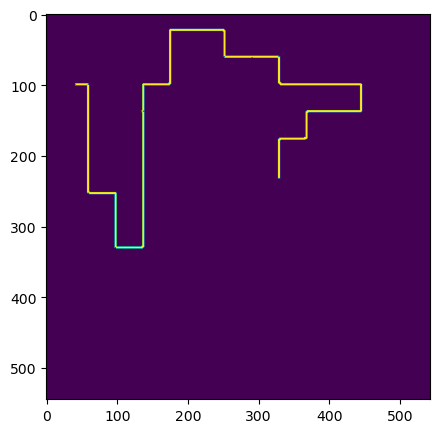

In [270]:
#let'go a temporanery copy of this
_mapt = np.copy(mapT)

#searching to our endpoint and connect to the path
boxr = 43

cpys, cpxs = np.where(_mapt[y2-boxr:y2+boxr, x2-boxr:x2+boxr]==0) #x e y di destinazione


#calibrate points to main scale
cpys += y2-boxr #x e y di destinazione
cpxs += x2-boxr

#find clooset point of possible path endpoints
idx = np.argmin(np.sqrt((cpys-y2)**2 + (cpxs-x2)**2)) #x e y di destinazione
y, x = cpys[idx], cpxs[idx]

pts_x = [x]
pts_y = [y]
pts_c = [0]

#mesh of displacements
xmesh, ymesh = np.meshgrid(np.arange(-1,2),np.arange(-1,2))
ymesh = ymesh.reshape(-1)
xmesh = xmesh.reshape(-1)

dst = np.zeros(thr_img.shape)

#Breath first algorithm exploring a tree
while(True):
    #update distance
    idc = np.argmin(pts_c)
    ct = pts_c.pop(idc)
    x3 = pts_x.pop(idc)
    y3 = pts_y.pop(idc)
    #Search 3x3 neighbourhood for possible
    ys, xs = np.where(_mapt[y3-1:y3+2,x3-1:x3+2] == 0) #x e y generici diversi da destinazione e arrivo
    #Invalidate these point from future searchers
    _mapt[ys+y3-1, xs+x3-1] = ct
    _mapt[y3,x3] = 999999
    #Set the distance in the distance image
    dst[ys+y3-1,xs+x3-1] = ct + 1
    #
    pts_x.extend(xs+x3-1)
    pts_y.extend(ys+y3-1)
    pts_c.extend([ct+1]*xs.shape[0])
    #If we run of points
    if pts_x == []:
        break;
    if np.sqrt((x3-x0)**2 +(y3-y0)**2) < boxr: #x0 prima partenza
        edx3 = x3
        edy3 = y3
        break;

plt.figure(figsize=(5,5))
plt.imshow(dst)

path_x3 = []
path_y3 = []

y3 = edy3
x3 = edx3
while(True):
    nbh = dst[y3-1:y3+2,x3-1:x3+2]
    nbh[1,1] = 9999999
    nbh[nbh==0] = 9999999
    #if we reach a deadend
    if np.min(nbh) == 9999999:
        break;
    idx = np.argmin(nbh)
    #find direction
    y3 += ymesh[idx]
    x3 += xmesh[idx]

    if np.sqrt((x3-x2)**2 + (y3-y2)**2) < boxr:   #arrivo
        print('Optimum route found.')
        break
    path_y3.append(y3)
    path_x3.append(x3)

#duplichiamo il while
while(True):
    #update distance
    idc = np.argmin(pts_c)
    ct = pts_c.pop(idc)
    x4 = pts_x.pop(idc)
    y4 = pts_y.pop(idc)
    #Search 3x3 neighbourhood for possible
    ys, xs = np.where(_mapt[y4-1:y4+2,x4-1:x4+2] == 0)
    #Invalidate these point from future searchers
    _mapt[ys+y4-1, xs+x4-1] = ct
    _mapt[y4,x4] = 999999
    #Set the distance in the distance image
    dst[ys+y4-1,xs+x4-1] = ct + 1
    #
    pts_x.extend(xs+x4-1)
    pts_y.extend(ys+y4-1)
    pts_c.extend([ct+1]*xs.shape[0])
    #If we run of points
    if pts_x == []:
        break;
    if np.sqrt((x4-x1)**2 +(y4-y1)**2) < boxr:  #x1 seconda partenza
        edx4 = x4
        edy4 = y4
        break;

plt.figure(figsize=(5,5))
plt.imshow(dst)

path_x4 = []
path_y4 = []

y4 = edy4
x4 = edx4
while(True):
    nbh = dst[y4-1:y4+2,x4-1:x4+2]
    nbh[1,1] = 9999999
    nbh[nbh==0] = 9999999
    #if we reach a deadend
    if np.min(nbh) == 9999999:
        break;
    idx = np.argmin(nbh)
    #find direction
    y4 += ymesh[idx]
    x4 += xmesh[idx]

    if np.sqrt((x4-x2)**2 + (y4-y2)**2) < boxr:   #arrivo
        print('Optimum route found.')
        break
    path_y4.append(y4)
    path_x4.append(x4)

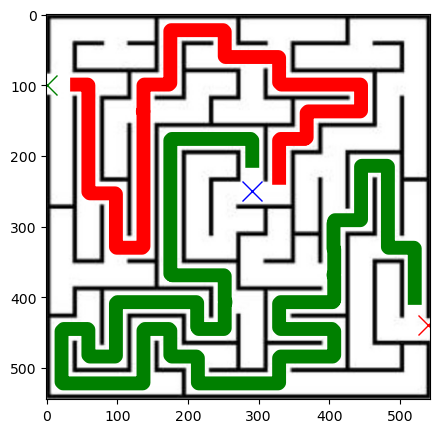

In [271]:
plt.figure(figsize=(5,5))
plt.imshow(rgb_img)
plt.plot(x0,y0, 'gx', markersize=14)
plt.plot(x1,y1, 'rx', markersize=14)
plt.plot(x2,y2, 'bx', markersize = 14)
plt.plot(path_x3, path_y3, 'r-', linewidth=10)
plt.plot(path_x4, path_y4, 'g-', linewidth=10)

In [66]:
#if rgb_image.shape.__len__() > 2:
#    thr_image = rgb_image[:,:,0] > np.max(rgb_image[:,:,0])/2
#else:
#    thr_image = rgb_image > np.max(rgb_image)/2
#skeleton = skeletonize(thr_image)
#plt.figure(figsize=(8,8))
#plt.imshow(skeleton)